In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import csv
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import sys
import os

: 

## Data loading

In [ ]:
data_tr = pd.read_csv('../data/train.csv')
data_te = pd.read_csv('../data/test.csv')

NameError: name 'pd' is not defined

In [ ]:
data_tr.head()
print(data_tr.shape)
data_tr.info()
data_te.info()

(1000, 325)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 325 entries, _STATE to TARGET
dtypes: bool(1), float64(318), int64(6)
memory usage: 2.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 324 entries, _STATE to ID
dtypes: float64(318), int64(6)
memory usage: 2.5 MB


# Data cleaning


In [ ]:
all_columns = data_tr.columns.values
# print(all_columns)
column_of_interest = ['SEXVAR', 'GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'POORHLTH', 'PRIMINSR', 'PERSDOC3', 'MEDCOST1', 'CHECKUP1', 'EXERANY2', 'SLEPTIM1', 'LASTDEN4', 'CVDSTRK3', 'ASTHMA3', 'ASTHNOW', 'CHCSCNC1', 'CHCOCNC1', 'CHCCOPD3', 'ADDEPEV3', 'CHCKDNY2', 'HAVARTH4', 'DIABETE4', 'WEIGHT2', 'HEIGHT3', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'SMOKE100', 'SMOKDAY2', 'USENOW3', 'ECIGNOW2', 'LCSFIRST', 'LCSLAST', 'LCSNUMCG', 'ALCDAY4', 'AVEDRNK3', 'DRNK3GE5', 'MAXDRNKS', 'FLUSHOT7', 'HIVRISK5', 'COVIDPOS', 'COVIDSMP', 'COVIDPRM', 'PDIABTS1', 'PREDIAB2', 'DIABTYPE', 'INSULIN1', 'CHKHEMO3', 'EYEEXAM1', 'FEETSORE', 'TOLDCFS', 'HAVECFS', 'WORKCFS', 'COVIDVA1', 'SHINGLE2', 'COPDCOGH', 'COPDFLEM', 'COPDBRTH', 'COPDBTST', 'COPDSMOK', 'CNCRDIFF', 'CNCRAGE', 'CNCRTYP2', 'CSRVDOC1', 'CIMEMLOS', 'CDHOUSE', 'CDASSIST', 'CDHELP', 'CDSOCIAL', 'ACEDEPRS', 'ACEDRINK', 'ACEDRUGS', 'ACEPRISN', 'ACEPUNCH', 'LSATISFY', 'EMTSUPRT', 'SDHISOLT', 'SDHEMPLY', 'FOODSTMP', 'SDHFOOD1', 'SDHSTRE1', 'MARIJAN1', 'MARJSMOK']

columns_to_delete = ['_STATE', 'FMONTH', 'IDATE', 'IMONTH', 'IDAY', 'IYEAR', 'SEQNO', 'Num', 'PVTRESD1', 'COLGHOUS', 'STATERE1', 'CELPHON1', 'NUMADULT', 'RESPSLCT', 'SAFETIME', 'CELLFON5', 'PVTRESD3', 'CCLGHOUS', 'CSTATE1', 'LANDLINE', 'CHILDREN']

target_column = ['TARGET']
id_column = ['ID']

k = 0
for c in column_of_interest :
    if c not in all_columns :
        print(f"column '{c}' is not in dataframe")
    else :
        k+=1
        #print("good")
        pass
print(k)

for c in columns_to_delete :
    if c not in all_columns :
        print(f"column '{c}' is not in dataframe")
    else :
        #print("good")
        pass

X_tr = data_tr[column_of_interest]
X_te = data_te[column_of_interest]

id_te = data_te[id_column]
y_tr = data_tr[target_column]   # Note, target column is not in test data

84
column 'Num' is not in dataframe


# Data Treatment

For correcting imbalances

In [ ]:
print(f"Shape of datatraining : {X_tr.shape}")
print(f"Shape of datatraining : {X_tr.dtypes}\n\n")

print("\nFor dftr")
for c in X_tr.columns.values :
    check_nan = X_tr[c].isnull().values.any()
    print(f"In column {c}\t NaN : {check_nan}".expandtabs(40))

Shape of datatraining : (1000, 84)
Shape of datatraining : SEXVAR      float64
GENHLTH     float64
PHYSHLTH    float64
MENTHLTH    float64
POORHLTH    float64
             ...   
FOODSTMP    float64
SDHFOOD1    float64
SDHSTRE1    float64
MARIJAN1    float64
MARJSMOK    float64
Length: 84, dtype: object



For dftr
In column SEXVAR                         NaN : False
In column GENHLTH                        NaN : False
In column PHYSHLTH                       NaN : False
In column MENTHLTH                       NaN : False
In column POORHLTH                       NaN : True
In column PRIMINSR                       NaN : False
In column PERSDOC3                       NaN : False
In column MEDCOST1                       NaN : False
In column CHECKUP1                       NaN : False
In column EXERANY2                       NaN : False
In column SLEPTIM1                       NaN : False
In column LASTDEN4                       NaN : True
In column CVDSTRK3                       NaN : Fa

# Feature engineering

In [ ]:
# Utils

def plot_nan_heatmap(matrix, xlabels, ylabels, width=800, height=500, plot=True, full_plotly_offline=False):
    """
    Heatmap NaN visualization using Plotly.
    Colors will be:
        NaN : black
        else : white
    Args:
        matrix: 2D array containing the data values
        xlabels: Labels for x-axis (columns)
        ylabels: Labels for y-axis (rows)
        plot: Whether to display the plot
        full_plotly_offline: Whether to include full Plotly JS in HTML output
    Returns:
        HTML string of the plot
    """
    # Convert to DataFrame
    df = pd.DataFrame(matrix, columns=xlabels, index=ylabels)

    # Create a NaN indicator matrix: 1 for NaN, 0 for non-NaN
    nan_indicator = df.isna().astype(int)

    # Plot the NaN indicator matrix
    fig = px.imshow(
        nan_indicator,
        width=width,
        height=height,
        template="plotly_white",
        color_continuous_scale="Greys",  # Use a grayscale gradient
        labels={"color": "NaN Proportion"},
        aspect="auto",
        zmin=0,
        zmax=1,
    )
    fig.update_xaxes(side="top", tickangle=45, tickfont=dict(size=5))
    fig.update_layout(
        margin=dict(pad=1),
        # title="Proportion of NaN Values (1 = NaN, 0 = Non-NaN)",

    )

    # Return or show
    if plot:
        fig.show()
    if full_plotly_offline:
        return fig.to_html(full_html=True)
    else:
        return fig.to_html(full_html=False, include_plotlyjs=False)
    
def plot_nan_bar(matrix, columns):
    """
    Bar plot of NaN proportion for each columns
    Args:
        matrix: 2D array containing the values
        columns: columns to visualize
    """
    nans_prop = X_tr.isna().mean()
    plt.bar(columns, height=nans_prop)
    print(nans_prop)
    plt.show()



In [ ]:
plot_nan_heatmap(X_tr.head(100), xlabels=column_of_interest, ylabels=range(100))

'<div>                            <div id="e9a90da5-02c7-484a-a065-b4718b096bc6" class="plotly-graph-div" style="height:500px; width:800px;"></div>            <script type="text/javascript">                window.PLOTLYENV=window.PLOTLYENV || {};                                if (document.getElementById("e9a90da5-02c7-484a-a065-b4718b096bc6")) {                    Plotly.newPlot(                        "e9a90da5-02c7-484a-a065-b4718b096bc6",                        [{"coloraxis":"coloraxis","name":"0","x":["SEXVAR","GENHLTH","PHYSHLTH","MENTHLTH","POORHLTH","PRIMINSR","PERSDOC3","MEDCOST1","CHECKUP1","EXERANY2","SLEPTIM1","LASTDEN4","CVDSTRK3","ASTHMA3","ASTHNOW","CHCSCNC1","CHCOCNC1","CHCCOPD3","ADDEPEV3","CHCKDNY2","HAVARTH4","DIABETE4","WEIGHT2","HEIGHT3","DECIDE","DIFFWALK","DIFFDRES","DIFFALON","SMOKE100","SMOKDAY2","USENOW3","ECIGNOW2","LCSFIRST","LCSLAST","LCSNUMCG","ALCDAY4","AVEDRNK3","DRNK3GE5","MAXDRNKS","FLUSHOT7","HIVRISK5","COVIDPOS","COVIDSMP","COVIDPRM","PDIABTS1","PRED

SEXVAR      0.000
GENHLTH     0.000
PHYSHLTH    0.000
MENTHLTH    0.000
POORHLTH    0.420
            ...  
FOODSTMP    0.457
SDHFOOD1    0.457
SDHSTRE1    0.460
MARIJAN1    0.787
MARJSMOK    0.973
Length: 84, dtype: float64


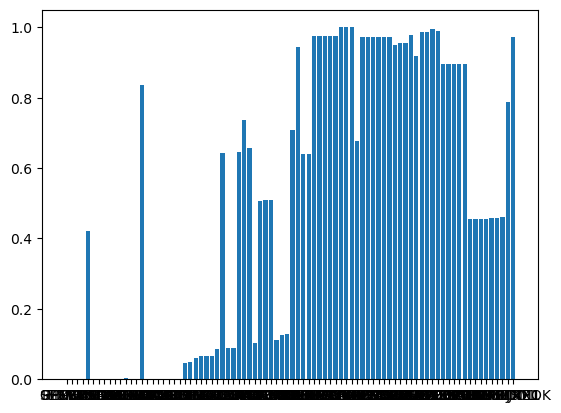

In [ ]:
plot_nan_bar(X_tr, column_of_interest)

In [ ]:
def rm_nan_columns(matrix, threshold=0.5):
    """
    Removes columns containing more than `threshold` fraction of NaNs.

    Parameters:
    matrix (pd.DataFrame): Input DataFrame
    threshold (float): Fraction of NaNs above which a column is removed (default: 0.5)

    Returns:
    pd.DataFrame: DataFrame with columns removed
    """
    print(f"We remove columns containing more than {threshold*100}% of NaNs")
    rem_cols = matrix.columns[matrix.isna().mean() > threshold]
    print("Columns to remove:", rem_cols)
    print(f"Number of columns to remove: {len(rem_cols)}")

    # Drop the columns and return the cleaned DataFrame
    cleaned_matrix = matrix.drop(columns=rem_cols)
    return cleaned_matrix

X_tr = rm_nan_columns(X_tr)
X_te = rm_nan_columns(X_te)

print(X_tr.shape)
print(X_te.shape)

We remove columns containing more than 50.0% of NaNs
Columns to remove: Index(['ASTHNOW', 'SMOKDAY2', 'LCSFIRST', 'LCSLAST', 'LCSNUMCG', 'AVEDRNK3',
       'DRNK3GE5', 'MAXDRNKS', 'COVIDSMP', 'COVIDPRM', 'PDIABTS1', 'PREDIAB2',
       'DIABTYPE', 'INSULIN1', 'CHKHEMO3', 'EYEEXAM1', 'FEETSORE', 'TOLDCFS',
       'HAVECFS', 'WORKCFS', 'COVIDVA1', 'SHINGLE2', 'COPDCOGH', 'COPDFLEM',
       'COPDBRTH', 'COPDBTST', 'COPDSMOK', 'CNCRDIFF', 'CNCRAGE', 'CNCRTYP2',
       'CSRVDOC1', 'CIMEMLOS', 'CDHOUSE', 'CDASSIST', 'CDHELP', 'CDSOCIAL',
       'ACEDEPRS', 'ACEDRINK', 'ACEDRUGS', 'ACEPRISN', 'ACEPUNCH', 'MARIJAN1',
       'MARJSMOK'],
      dtype='object')
Number of columns to remove: 43
We remove columns containing more than 50.0% of NaNs
Columns to remove: Index(['ASTHNOW', 'SMOKDAY2', 'LCSFIRST', 'LCSLAST', 'LCSNUMCG', 'AVEDRNK3',
       'DRNK3GE5', 'MAXDRNKS', 'COVIDSMP', 'COVIDPRM', 'PDIABTS1', 'PREDIAB2',
       'DIABTYPE', 'INSULIN1', 'CHKHEMO3', 'EYEEXAM1', 'FEETSORE', 'TOLDCFS',
    

## Correct imbalances

In [ ]:
def increase_positive(df, target_column, v_target=1.0, increase_by=4):
    dfp = df[df[target_column]==v_target]
    return pd.concat([df]+[dfp]*increase_by, axis=0)

increase_positive(X_tr, y_tr)
print(X_tr.shape)

(1000, 41)


Instead of removing all lines with NaNs, which will result on not enough data, we will replace NaNs values that are representative of the columns

In first instance, for categories with NaNs, we will replace those NaNs with the catagoriy that is the most present

In [ ]:
import pandas as pd

def replace_nan(df, replace_by='median'):
    """
    Replaces NaN values in each column of a DataFrame with the most frequent value (mode),
    mean, or median of that column.

    Parameters:
    df (pd.DataFrame): Input DataFrame
    replace_by (str): Method to replace NaN values. Options: 'mode', 'mean', 'median'

    Returns:
    pd.DataFrame: DataFrame with NaN values replaced by the specified method for each column

    Raises:
    ValueError: If replace_by is not one of 'mode', 'mean', or 'median'
    """
    clean_df = df.copy()

    if replace_by not in ['mode', 'mean', 'median']:
        raise ValueError("replace_by must be 'mode', 'mean', or 'median'")

    for column in clean_df.columns:
        if replace_by == 'mode':
            mode = clean_df[column].mode()
            if not mode.empty:
                clean_df[column] = clean_df[column].fillna(mode[0])
            else:
                print(f"Column {column}: Could not calculate mode.")
        elif replace_by == 'mean':
            mean = clean_df[column].mean()
            clean_df[column] = clean_df[column].fillna(mean)
        elif replace_by == 'median':
            median = clean_df[column].median()
            clean_df[column] = clean_df[column].fillna(median)

    return clean_df



X_tr_mode = replace_nan(X_tr)
y_tr.to_numpy().ravel()
# plot_nan_proportion_heatmap(X_tr_mode.head(), xlabels=X_tr_mode.columns, ylabels=range(10))

X_tr.shape
X_te.shape

(1000, 41)

# Prediction tah jai la vision

In [ ]:
rf = RandomForestClassifier(n_estimators=101, criterion='log_loss', max_depth=6)
rf.fit(X_tr_mode, y_tr)


/home/hugoat/anaconda3/envs/SDDenv/lib/python3.12/site-packages/sklearn/base.py:1365: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



,n_estimators,101
,criterion,'log_loss'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
print(X_tr.shape)
print(X_tr_mode.shape)
print(X_te.shape)


(1000, 41)
(1000, 41)
(1000, 41)


In [ ]:
sys.path.append(os.path.abspath("../soumission"))


def soumission_csv(model,df_data,indexes,filename="../data/prediction.csv"):
    """
    Génère un fichier csv de predictions reponse à soumettre à partir d'un model entrainé et d'un data_frame.
        
    Paramètres :
    - model, model entrainé 
    - df_data : data frame des données à predire, dois contenir la colone "ID" et les meme features que le model entrainé
    - filename : nom du fichier créé par la fonction
    """   
    
    features = df_data.drop(columns=["ID"], errors='ignore')

    prediction = model.predict(features)

    with open(filename, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["ID", "TARGET"])  # En-têtes
        print(indexes)
        id_array = indexes['ID'].to_numpy()
        for idx in range(len(prediction)) :
            print(idx)
            writer.writerow([idx, prediction[idx]])
    print(f"Fichier '{filename}' créé avec succès !")
    return



soumission_csv(rf, X_te, id_te,"../data/prediction_colon_of_interest.csv")

         ID
0    225000
1    225001
2    225002
3    225003
4    225004
..      ...
995  225995
996  225996
997  225997
998  225998
999  225999

[1000 rows x 1 columns]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
2